## Theano implemented RBF and chi-squared kernels vs. sklearn <br>
In training relatively large (1500 x 4000 training data size in my case) support vector machines, the main time component is the calculation of a Gram matrix (or Kernel matrix). This is effectively a full pairwise distance matrix between instances - the number of operations is therefore polynomial in the number of dimensions and samples.

My data is actually multichannel, necessitating calculating 5 Gram matrices instead of one - so I turned to Theano and a GPU to try to speed up the kernel computations.

In [168]:
%matplotlib inline
from multichannel_svr.theano_kernels import theano_rbf, theano_chi2
from sklearn.metrics.pairwise import rbf_kernel, chi2_kernel
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [171]:
#run theano functions to compile computational graph
_ = theano_rbf(np.random.random((10,10)), np.random.random((10,10)))
_ = theano_chi2(np.random.random((10,10)), np.random.random((10,10)))

In [172]:
#utility func for timing
def time_algo(algo, X, Y):
    t0 = time()
    _ = algo(X,Y)
    return time() - t0

In [78]:
#do grid search across number of dimensions/observations
#for RBF
exponent_list = range(14)
num_obs_list = [2**xi for xi in exponent_list]
num_dim_list = [2**xi for xi in exponent_list]

#result array
result_array_rbf = np.empty((len(exponent_list),len(exponent_list),2)) #third dim is for different implementations

#loop over nums
for obs_ind, num_obs in enumerate(num_obs_list):
    for dim_ind, num_dim in enumerate(num_dim_list):
        
        num_its = 3
        loop_array = np.empty((num_its,1,2)) #
        for ii in range(num_its):
            X = np.random.random((num_obs, num_dim))
            loop_array[ii,0,0] = time_algo(theano_rbf, X, X)
            loop_array[ii,0,1] = time_algo(rbf_kernel, X, X)
        
        #take mean of the n runs
        loop_result = np.mean(loop_array, axis=0, keepdims=True)
        
        #put into result array
        result_array_rbf[obs_ind, dim_ind, :] = loop_result
            

In [ ]:
#do grid search across number of dimensions/observations
#for RBF
exponent_list = range(14)
num_obs_list = [2**xi for xi in exponent_list]
num_dim_list = [2**xi for xi in exponent_list]

#result array
result_array_chi2 = np.empty((len(exponent_list),len(exponent_list),2)) #third dim is for different implementations

#loop over nums
for obs_ind, num_obs in enumerate(num_obs_list):
    for dim_ind, num_dim in enumerate(num_dim_list):
        
        num_its = 1
        loop_array = np.empty((num_its,1,2)) #
        for ii in range(num_its):
            X = np.random.random((num_obs, num_dim))
            loop_array[ii,0,0] = time_algo(theano_chi2, X, X)
            loop_array[ii,0,1] = time_algo(chi2_kernel, X, X)
        
        #take mean of the n runs
        loop_result = np.mean(loop_array, axis=0, keepdims=True)
        
        #put into result array
        result_array_chi2[obs_ind, dim_ind, :] = loop_result

In [169]:
#plot result
def plot_heatmap(result_array, numerator_layer=1, denominator_layer=0, figsize=(15,12), axis_start=0, text_label=False):

    #prep the data
    data = result_array[:,:,numerator_layer] / result_array[:,:,denominator_layer]

    #draw the data
    fig, ax = plt.subplots(figsize=figsize)
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    #set the ticks
    ax.set_xticks(np.arange(data.shape[0])+.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+.5, minor=False)
    ax.set_xticklabels(np.arange(data.shape[0])+axis_start)
    ax.set_yticklabels(np.arange(data.shape[1])+axis_start)

    #axis labels
    axis_fontdict={'fontsize': 14}
    ax.set_xlabel(r'Observations (2$^x$)', labelpad=20, fontdict=axis_fontdict)
    ax.set_ylabel(r'Dimensions (2$^x$)', labelpad=20, fontdict=axis_fontdict)
    
    #colorbar
    cb = fig.colorbar(heatmap)
    cb.set_label('Ratio of time taken (sklearn / theano)', labelpad=20, fontdict=axis_fontdict)
    
    #write text on squares
    if text_label:
        for y in range(data.shape[1]):
            for x in range(data.shape[0]):
                ax.text(x+.5, y+.5, '%.2f'%data[x,y],
                        horizontalalignment='center',
                        verticalalignment='center',
                        #weight='bold',
                        fontsize=14)
    
    return fig, ax


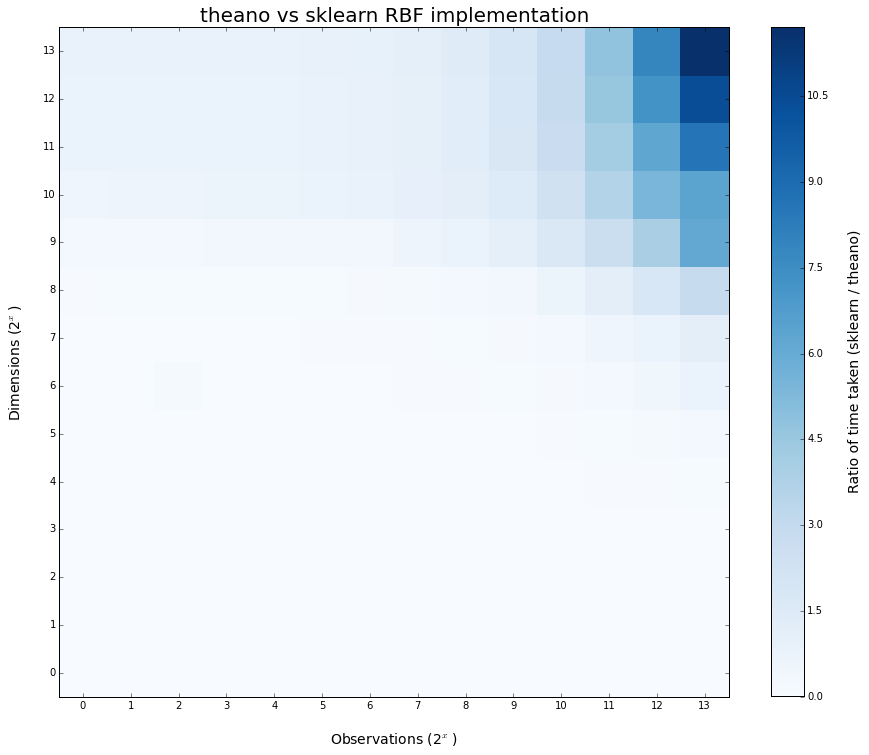

In [160]:
fig, ax = plot_heatmap(result_array)
ax.set_title('theano vs sklearn RBF implementation', fontdict={'fontsize': 20})

In [ ]:
fig, ax = plot_heatmap(result_array[7:,7:,:], axis_start=7, text_label=True, figsize=(10,8))
ax.set_title('theano vs sklearn RBF implementation (detail)', fontdict={'fontsize': 20})